# Sistema de recomendação
## Passo 1 Vamos primeiro carregar e examinar os dados com os quais trabalharemos.

In [ ]:
from scipy.io import loadmat

data = loadmat('MLs15e recomendacao de filmes.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Número de filmes x número de usuários

Y Contém a classificações de 1 a 5. 

R contém a avaliação com valores binários que indicam se um usuário classificou um filme ou não.

Ambos devem ter a mesma forma.

In [ ]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

Podemos observar a classificação média de um filme calculando a média de uma linha em Y para índices em que uma classificação está presente.

In [ ]:
import numpy as np
Y[1, np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

## Passo 2 Visualizar os dados renderizando a matriz como se fosse uma imagem. Isso nos dá uma ideia de uma densidade relativa de classificações entre usuários e filmes.

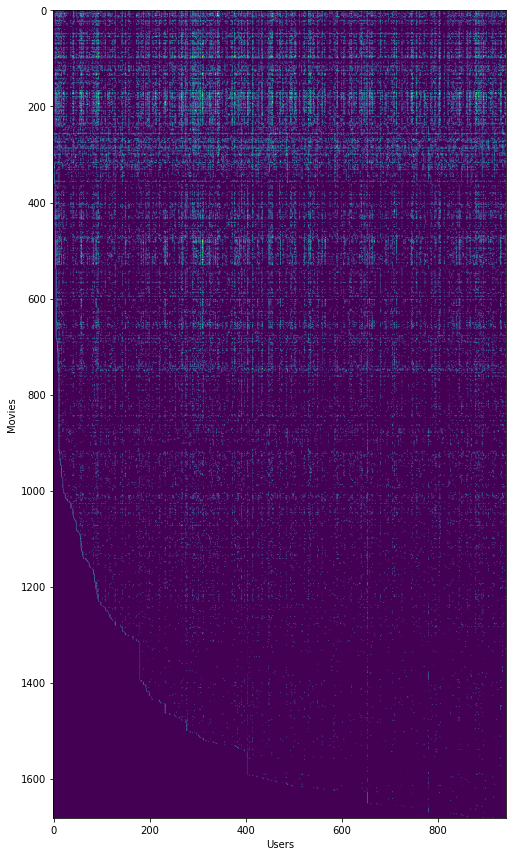

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

Vamos implementar uma função de custo para filtragem colaborativa. Intuitivamente, o "custo" é o grau em que um conjunto de previsões de classificação de filmes se desvia das previsões verdadeiras.

A equação de custo é baseado em dois conjuntos de matrizes de parâmetros chamados X e Theta. Eles são "desenrolados" na entrada "params" para que possamos usar o pacote de otimização do SciPy posteriormente.

In [ ]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # remodelar a matriz de parâmetros em matrizes de parâmetros
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    J = 0
    
    # Calcular o custo
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

# Passo 3 Teste com um conjunto de parâmetros pré-treinados que podemos avaliar.

In [ ]:
params_data = loadmat('MLs15e recomendacao de filmes param.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [ ]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

## Passo 4 Precisamos implementar os cálculos de gradiente. Estenderemos a função de custo para também calcular os gradientes.

In [ ]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]    
    # remodelar a matriz de parâmetros em matrizes de parâmetros
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    J = 0 # Inicialização
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    # Calcular o custo
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    # Calcular os gradientes
    X_grad = error * Theta
    Theta_grad = error.T * X    
    # Unificar as matrizes de gradiente em uma única matriz
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    return J, grad

J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

## Passo 5 Criaremos uma versão final regularizada da função que inclui um parâmetro adicional de "taxa de aprendizado", chamado "lambda".

In [ ]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    # remodelar a matriz de parâmetros em matrizes de parâmetros
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    J = 0 # Inicialização
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    # Calcular o custo
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    # Adicionar o regularização de custo
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    # Calcular os gradientes com regularização
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    return J, grad

J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

## Passo 6 Esse resultado novamente corresponde à saída esperada do código, então parece que a regularização está funcionando. Antes de treinarmos o modelo, temos uma etapa final. Temos a tarefa de criar nossas próprias classificações de filmes para que possamos usar o modelo para gerar recomendações personalizadas. Um arquivo é fornecido para vincular o índice do filme ao seu título. Vamos carregar o arquivo em um dicionário.

In [ ]:
movie_idx = {}
f = open('MLs15e recomendacao de filmes ids.txt', encoding='utf8', errors='ignore') #encoding="ISO-8859-1")
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

movie_idx[0]

'Toy Story (1995)'

Usaremos as classificações fornecidas no exercício.

In [ ]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))


Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


## Passo 7 Adicionar nosso próprio vetor de classificações ao conjunto de dados existente para incluir no modelo.

In [ ]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682, 944), (1682, 944), (1682, 1))

## Passo 8 Treinar o modelo de filtragem colaborativa. Só precisamos definir algumas variáveis e normalizar as classificações.

In [ ]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [ ]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

5.507036456515984e-19

In [ ]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 38955.07730195086
     jac: array([-0.04828901, -0.01275537,  0.00075598, ..., -0.0051109 ,
       -0.00089658, -0.00453127])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 140
     nit: 100
    njev: 140
  status: 1
 success: False
       x: array([ 0.46804032, -0.0500267 , -0.79652723, ...,  0.09211611,
        0.00137446, -0.05340426])

In [ ]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

##Passo 9 Testar - Nossos parâmetros treinados estão agora em X e Theta. Podemos usá-los para criar algumas recomendações para o usuário que adicionamos.

In [ ]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

(1682, 1)

In [ ]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[5.00000013],
        [5.00000004],
        [5.00000002],
        [5.00000002],
        [5.        ],
        [5.        ],
        [5.        ],
        [5.        ],
        [4.99999984],
        [4.99999982]])

Lista ordenada das principais classificações, mas perdemos para qual índice essas classificações são. Na verdade, precisamos usar o argsort para sabermos a qual filme a classificação prevista corresponde.

In [ ]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

matrix([[1292],
        [1200],
        [1188],
        ...,
        [ 438],
        [1333],
        [1358]])

In [ ]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.000000130093816 for movie Star Kid (1997).
Predicted rating of 5.00000003890933 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.000000023984627 for movie Prefontaine (1997).
Predicted rating of 5.000000023364512 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.000000002375237 for movie They Made Me a Criminal (1939).
Predicted rating of 5.00000000095726 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 4.999999998684397 for movie Santa with Muscles (1996).
Predicted rating of 4.999999995505462 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.999999835336569 for movie Someone Else's America (1995).
Predicted rating of 4.9999998224382205 for movie Aiqing wansui (1994).
